### Importion des librairies

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
import joblib

In [7]:
# Charger la base de données
df = pd.read_csv("../data/raw/churn.csv")

In [13]:
# Copie la base de données originale
df_clean = df.copy()
df_clean.head()

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,2.0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,1.0
1,3.0,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.0,6.0,1.0
2,4.0,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.0,3.0,1.0
3,5.0,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.0,29.0,1.0
4,6.0,23.0,Male,32.0,20.0,5.0,8.0,Basic,Monthly,617.0,20.0,1.0


In [14]:
# Suppression de la colonne 'CustomerID'
df_clean.drop(columns=['CustomerID'], inplace=True)

# Suppression de NaN
df_clean.dropna(inplace=True)

### Standadisation des noms de colonnes

In [15]:
df_clean.columns = df_clean.columns.str.lower().str.replace(' ', '_')

print("Nouveaux noms de colonnes :", list(df_clean.columns))

Nouveaux noms de colonnes : ['age', 'gender', 'tenure', 'usage_frequency', 'support_calls', 'payment_delay', 'subscription_type', 'contract_length', 'total_spend', 'last_interaction', 'churn']


### Encodage (Transformation des textes en nombres)

#### Encodage Ordinal (Hiérarchique)

In [16]:
# On définit manuellement l'ordre pour que le modèle comprenne la progression
ordinal_cols = ['subscription_type', 'contract_length']
ordinal_order = [
    ['Basic', 'Standard', 'Premium'],       # 0=Basic, 1=Standard, 2=Premium
    ['Monthly', 'Quarterly', 'Annual']      # 0=Mensuel, 1=Trimestriel, 2=Annuel
]

# On applique l'encodage
ord_enc = OrdinalEncoder(categories=ordinal_order)
# On force la conversion en entiers (int) pour être propre
df_clean[ordinal_cols] = ord_enc.fit_transform(df_clean[ordinal_cols]).astype(int)

#### Encodage Nominal

In [17]:
df_encoded = pd.get_dummies(df_clean, columns=['gender'], drop_first=True, dtype=int)

# On re-standardise tout en minuscule pour être sûr d'avoir 'gender_male'
df_encoded.columns = df_encoded.columns.str.lower()

### Conversion & Réorganisation 

In [18]:
# Conversion de la cible en Entier (int)
df_encoded['churn'] = df_encoded['churn'].astype(int)

In [19]:
# Réorganisation des colonnes
# On identifie les colonnes spéciales
target_col = 'churn'
penultimate_col = 'gender_male'

# On récupère toutes les autres colonnes
other_cols = [c for c in df_encoded.columns if c not in [target_col, penultimate_col]]

# On construit le nouvel ordre : 
new_order = other_cols + [penultimate_col, target_col]
df_encoded = df_encoded[new_order]

In [20]:
# Petite vérification visuelle
print("Aperçu des données encodées :")
display(df_encoded.head())

Aperçu des données encodées :


,age,tenure,usage_frequency,support_calls,payment_delay,subscription_type,contract_length,total_spend,last_interaction,gender_male,churn
0,30.0,39.0,14.0,5.0,18.0,1,2,932.0,17.0,0,1
1,65.0,49.0,1.0,10.0,8.0,0,0,557.0,6.0,0,1
2,55.0,14.0,4.0,6.0,18.0,0,1,185.0,3.0,0,1
3,58.0,38.0,21.0,7.0,7.0,1,0,396.0,29.0,1,1
4,23.0,32.0,20.0,5.0,8.0,0,0,617.0,20.0,1,1


### Split & Scaling

In [21]:
X = df_encoded.drop('churn', axis=1)
y = df_encoded['churn']

# Split Stratifié
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (404164, 10)
X_test shape: (101042, 10)
y_train shape: (404164,)
y_test shape: (101042,)


In [22]:
# Standardisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [26]:
# Conversion en DataFrame final
X_train_final = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_final = pd.DataFrame(X_test_scaled, columns=X.columns)

In [24]:
# Enregistrement des 4 fichiers
X_train_final.to_csv('../data/processed/X_train.csv', index=False)
X_test_final.to_csv('../data/processed/X_test.csv', index=False)
y_train.to_csv('../data/processed/y_train.csv', index=False)
y_test.to_csv('../data/processed/y_test.csv', index=False)

In [31]:
# Sauvegarde du scaler
joblib.dump(scaler, '../models/scaler.pkl')

['../models/scaler.pkl']

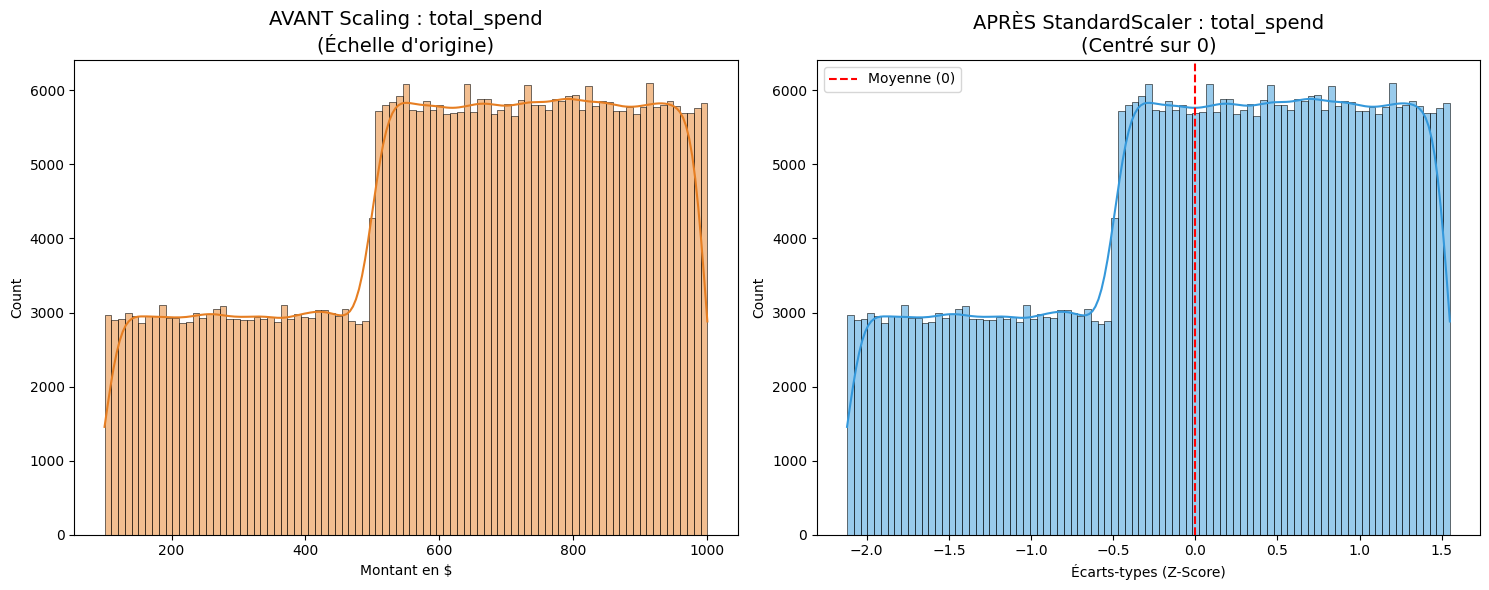

Moyenne Avant : 620.01
Moyenne Après : 0.00
Ecart-type Après : 1.00


In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# On choisit une variable parlante, par exemple 'total_spend'
variable_to_plot = 'total_spend'

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# --- GRAPHIQUE 1 : AVANT SCALING ---
# On prend les données brutes dans X_train (avant transformation)
sns.histplot(X_train[variable_to_plot], kde=True, ax=axes[0], color="#e67e22")
axes[0].set_title(f"AVANT Scaling : {variable_to_plot}\n(Échelle d'origine)", fontsize=14)
axes[0].set_xlabel("Montant en $")

# --- GRAPHIQUE 2 : APRÈS SCALING ---
# On prend les données transformées dans X_train_final
sns.histplot(X_train_final[variable_to_plot], kde=True, ax=axes[1], color="#3498db")
axes[1].set_title(f"APRÈS StandardScaler : {variable_to_plot}\n(Centré sur 0)", fontsize=14)
axes[1].set_xlabel("Écarts-types (Z-Score)")

# Ajout d'une ligne verticale à 0 pour bien montrer le centrage
axes[1].axvline(0, color='red', linestyle='--', label='Moyenne (0)')
axes[1].legend()

plt.tight_layout()
plt.show()

# Petite vérification statistique
print(f"Moyenne Avant : {X_train[variable_to_plot].mean():.2f}")
print(f"Moyenne Après : {X_train_final[variable_to_plot].mean():.2f}")
print(f"Ecart-type Après : {X_train_final[variable_to_plot].std():.2f}")